The NHS 10 year plan comits the NHS to shifting from MDI to DPI. This notebook seeks to describe the trends and variation and model the cost of such a policy on the medicines budget

In [1]:
### here we import various libraries needed
import pandas as pd
import numpy as np
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# taken from https://github.com/jrmontag/STLDecompose
# requires installation - pip install stldecompose
from stldecompose import decompose
# Simpler smoothing uses:
# from statsmodels.tsa.seasonal import seasonal_decompose

#import geopandas as gpd


ModuleNotFoundError: No module named 'stldecompose'

In [3]:
## Here we query our prescribing file to create a dataframe of all inhaler prescribing
sql = '''
SELECT
  pct,
  pract.name,
  presc.practice,
  AVG(total_list_size) AS list_size,
  presc.month,
  SUM(IF(form_route='powderinhalation.inhalation', ##from dmd, identifies a DPI 
      items,
      0)) AS dpi,
      SUM(IF(form_route='pressurizedinhalation.inhalation',  ##from dmd, identifies a MDI
      items,
      0)) AS mdi,
      SUM(items) AS totalinhalers,
    SUM(actual_cost) AS totalcost
   FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
LEFT JOIN
  ebmdatalab.hscic.practices AS pract
ON
  presc.practice=pract.code
  AND pract.setting=4 ## I have restricted to "normal" general practice. Review choice with team
LEFT JOIN  # is this join in the right place  review
  ebmdatalab.hscic.practice_statistics_all_years AS stat
ON
  presc.practice = stat.practice
  AND presc.month = stat.month
LEFT JOIN
  ebmdatalab.dmd.form_dose AS dmd
ON
  presc.bnf_code=dmd.bnf_code
WHERE
  presc.bnf_code LIKE "030%"
AND (form_route="powderinhalation.inhalation"
    OR form_route= "pressurizedinhalation.inhalation")
GROUP BY
  pct,
  name,
  practice,  
  month
  '''


df_inhaler = bq.cached_read(sql, csv_path='df_inhaler.csv', use_cache=True)  # add `use_cache=False` to override
df_inhaler['month'] = df_inhaler['month'].astype('datetime64[ns]')
df_inhaler.head()

C:\Users\racro\Anaconda3\lib\site-packages\pandas\io\gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


,pct,name,practice,list_size,month,dpi,mdi,totalinhalers,totalcost
0,05X,LINDEN HALL SURGERY,M82056,12898.0,2015-08-01,268,453,721,25637.07
1,07V,QUEENHILL MEDICAL PRACTICE,H83014,7253.0,2015-08-01,153,197,350,9622.06
2,07L,FIVE ELMS MEDICAL PRACTICE,F82012,4385.0,2015-08-01,133,183,316,7905.38
3,02H,DR ANDERSON & DR AHMED,P92605,5927.0,2015-08-01,116,371,487,13075.53
4,06H,TRUMPINGTON STREET MEDICAL PRACTICE,D81013,13730.0,2015-08-01,112,314,426,12357.98


In [4]:
# here we calculate current proportion of inhalers prescribed as DPI
df_inhaler["per_dpi"] = 100*(df_inhaler.dpi/(df_inhaler.dpi+df_inhaler.mdi)).fillna(0)

df_inhaler.head()

,pct,name,practice,list_size,month,dpi,mdi,totalinhalers,totalcost,per_dpi
0,05X,LINDEN HALL SURGERY,M82056,12898.0,2015-08-01,268,453,721,25637.07,37.170596
1,07V,QUEENHILL MEDICAL PRACTICE,H83014,7253.0,2015-08-01,153,197,350,9622.06,43.714286
2,07L,FIVE ELMS MEDICAL PRACTICE,F82012,4385.0,2015-08-01,133,183,316,7905.38,42.088608
3,02H,DR ANDERSON & DR AHMED,P92605,5927.0,2015-08-01,116,371,487,13075.53,23.819302
4,06H,TRUMPINGTON STREET MEDICAL PRACTICE,D81013,13730.0,2015-08-01,112,314,426,12357.98,26.291080


In [5]:
# here I repeated this...........this isproblem when doing in snatched time and big gaps in between!
pc = df_inhaler.copy()
pc["percentage_dpi"] = 100*(pc.dpi/(pc.dpi+pc.mdi)).fillna(0)
pc.head()

,pct,name,practice,list_size,month,dpi,mdi,totalinhalers,totalcost,per_dpi,percentage_dpi
0,05X,LINDEN HALL SURGERY,M82056,12898.0,2015-08-01,268,453,721,25637.07,37.170596,37.170596
1,07V,QUEENHILL MEDICAL PRACTICE,H83014,7253.0,2015-08-01,153,197,350,9622.06,43.714286,43.714286
2,07L,FIVE ELMS MEDICAL PRACTICE,F82012,4385.0,2015-08-01,133,183,316,7905.38,42.088608,42.088608
3,02H,DR ANDERSON & DR AHMED,P92605,5927.0,2015-08-01,116,371,487,13075.53,23.819302,23.819302
4,06H,TRUMPINGTON STREET MEDICAL PRACTICE,D81013,13730.0,2015-08-01,112,314,426,12357.98,26.291080,26.291080


In [6]:
pc.practice.drop_duplicates().count()

11031

In [7]:
# filter for "normal" practices
filtered = df_inhaler.copy().loc[(df_inhaler.list_size>1000) & (df_inhaler["month"]>"2010-09-01") ]  
filtered.head()

#deciles,perecentiles etc.

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))

#filtered tables grouped by months
pcf = filtered.groupby('month').quantile(x)

#putting groupby(month) from index back into being a column
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf.head(5)

,month,percentile,dpi,list_size,mdi,per_dpi,totalcost,totalinhalers
0,2010-10-01,0.1,38.0,2344.4,109.0,17.035869,3626.638,160.0
1,2010-10-01,0.2,59.0,3136.4,158.0,20.836673,5314.334,228.0
2,2010-10-01,0.3,79.0,4017.6,206.0,23.547333,7090.540,294.0
3,2010-10-01,0.4,100.0,4991.6,258.0,26.069880,9010.118,369.0
4,2010-10-01,0.5,125.0,6040.0,316.0,28.571429,11143.170,454.0


In [8]:
filtered.practice.drop_duplicates().count()

8118

## Current trends in prescribing

In [9]:
# here we code for plots of current prescribing trends over time

sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = df_inhaler.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
data = df_inhaler.groupby('month').sum()[['totalinhalers','list_size']]
data = pd.DataFrame(data['totalinhalers'])
data["totalinhalers"] = data["totalinhalers"]

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))#/data)*100

#total inhalers
ax = plt.subplot(gs[0,0])
ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('items', size =15, alpha=0.6)
ax.set_title('(a) Total Inhalers prescribed',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
max_value = data["totalinhalers"].max()*1.05
ax.set_ylim([0,max_value])
ax.legend(prop={'size': 14})


#total DPI inahlers
ax = plt.subplot(gs[0,1])
data = df_inhaler.groupby('month').sum()[['dpi', 'list_size']]
data = pd.DataFrame(data['dpi'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('items', size =15, alpha=0.6)
ax.set_title('(b) DPI prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,max_value])
ax.legend(prop={'size': 14})


#MDI Inhalers
ax = plt.subplot(gs[1,0])
data = df_inhaler.groupby('month').sum()[['mdi','list_size']]
data = pd.DataFrame(data['mdi'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('items', size =15, alpha=0.6)
ax.set_title('(c) MDI prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})

plt.show()

NameError: name 'decompose' is not defined

<Figure size 1152x1440 with 0 Axes>

# Practice Deciles of DPI Usage

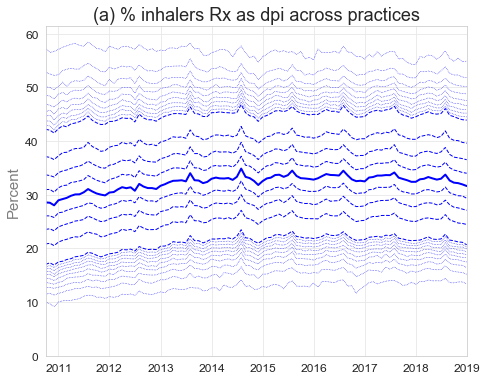

In [10]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
# order is column, title, axis
s = [(0,'per_dpi',0,0,'(a) % inhalers Rx as dpi across practices','Percent'),]


x = pd.Series(x)
fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show() 

In [13]:
pcf.head()

,month,percentile,dpi,list_size,mdi,per_dpi,totalcost,totalinhalers
0,2010-10-01,0.1,38.0,2344.4,109.0,17.035869,3626.638,160.0
1,2010-10-01,0.2,59.0,3136.4,158.0,20.836673,5314.334,228.0
2,2010-10-01,0.3,79.0,4017.6,206.0,23.547333,7090.540,294.0
3,2010-10-01,0.4,100.0,4991.6,258.0,26.069880,9010.118,369.0
4,2010-10-01,0.5,125.0,6040.0,316.0,28.571429,11143.170,454.0


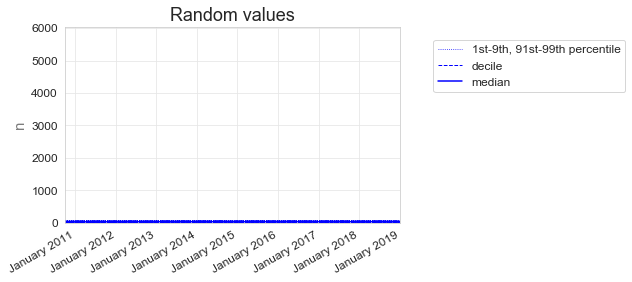

In [14]:
plt = charts.deciles_chart(
        pcf,
        period_column='month',
        column='per_dpi',
        title="Random values",
        ylabel="n",
        show_outer_percentiles=True,
        show_legend=True
)

### Maps for 2018

In [15]:
latest_pcf = pcf.loc[pcf['month'] == '2018-12-01']
plt = maps.ccg_map(latest_pcf, title="Proportion of CMPA prescribing as AAF \n(December 2018)", column='per_dpi', cartogram=False)
plt.show()

KeyError: 'pct'

In [12]:
#aggregate over 2018
ccg_last_year = df_inhaler.groupby(['pct','month'],as_index=False).sum()
ccg_last_year = ccg_last_year.loc[(ccg_last_year["month"]>="2018-01-01") & (ccg_last_year["month"]<="2018-12-01")]

#ccg_last_year = all_inhalers_ccg.loc[all_inhalers_ccg.month]
ccg_last_year = ccg_last_year.groupby('pct').sum()
ccg_last_year["list_size"] = ccg_last_year["list_size"]/12

df_inhaler["per_dpi"] = 100*(df_inhaler.dpi/(df_inhaler.dpi+df_inhaler.mdi)).fillna(0)
df_inhaler["costperinh"] = (df_inhaler.totalcost/df_inhaler.totalinhalers).fillna(0)

ccg_last_year["per_dpi"] = 100*(ccg_last_year.dpi/(ccg_last_year.dpi+ccg_last_year.mdi)).fillna(0)


ccg_last_year.head()

,list_size,dpi,mdi,totalinhalers,totalcost,per_dpi
pct,,,,,,
00C,108423.333333,59653,80420,140073,3.236474e+06,42.587080
00D,292336.000000,214874,320164,535038,1.058912e+07,40.160512
00J,259779.833333,142789,214871,357660,7.242765e+06,39.923111
00K,297508.166667,183635,292898,476533,1.009143e+07,38.535631
00L,325704.916667,221356,247103,468459,1.021576e+07,47.251947


In [14]:
sql='''
SELECT
  DISTINCT code,
  name
FROM
  ebmdatalab.hscic.ccgs
WHERE
  name IS NOT NULL'''

names = bq.cached_read(sql, csv_path='names.csv', use_cache=True)
names.head(5)

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas_gbq\gbq.py:556: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  "verbosity", FutureWarning, stacklevel=1)


,code,name
0,00T,NHS BOLTON CCG
1,14C,WEST MIDLANDS COMMISSIONING HUB
2,05N,NHS SHROPSHIRE CCG
3,01E,NHS GREATER PRESTON CCG
4,11H,NHS BRISTOL CCG


In [15]:
# join to geographical data
map_data = ccg_last_year.reset_index()
names = names.rename(columns={"CCG17CDH":"code","CCG17NM":"name"})
map_data = map_data.merge(names[['code','name']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
#map_data = map_data.round(0)
map_data.head() 

,pct,list_size,dpi,mdi,totalinhalers,totalcost,per_dpi,code
name,,,,,,,,
NHS DARLINGTON CCG,00C,108423.333333,59653,80420,140073,3.236474e+06,42.587080,00C
"NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG",00D,292336.000000,214874,320164,535038,1.058912e+07,40.160512,00D
NHS NORTH DURHAM CCG,00J,259779.833333,142789,214871,357660,7.242765e+06,39.923111,00J
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,00K,297508.166667,183635,292898,476533,1.009143e+07,38.535631,00K
NHS NORTHUMBERLAND CCG,00L,325704.916667,221356,247103,468459,1.021576e+07,47.251947,00L


In [16]:
from urllib.request import urlopen
from urllib.request import Request
import json
url = "https://openprescribing.net/api/1.0/org_location/?org_type=ccg"
hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
req = Request(url, headers=hdr)
page = urlopen(req)
json_file = json.loads(page.read().decode())
with open('ccgs.json', 'w') as outfile:
    json.dump(json_file, outfile)

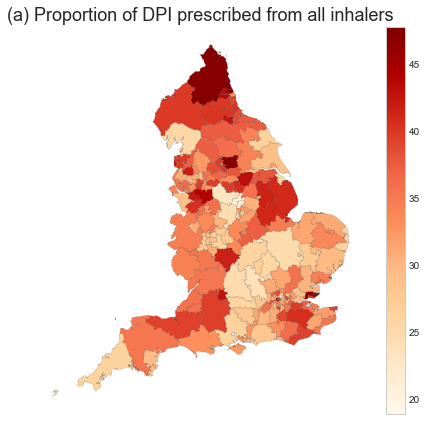

In [18]:
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,"per_dpi",0,0,'(a) Proportion of DPI prescribed from all inhalers'),]     

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.07)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

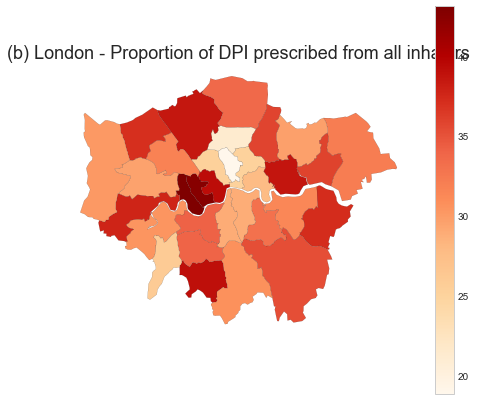

In [19]:
plt.show()# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)
gdf = gdf.loc[(gdf["pct"]=="08H") 
              | (gdf["pct"]=="07L")
              | (gdf["pct"]=="07M")
              | (gdf["pct"]=="07N")
              | (gdf["pct"]=="8M")
              | (gdf["pct"]=="07P")
              | (gdf["pct"]=="07Q")
              | (gdf["pct"]=="07R")
              | (gdf["pct"]=="09A")
              | (gdf["pct"]=="07T")
              | (gdf["pct"]=="07V")
              | (gdf["pct"]=="07X")
              | (gdf["pct"]=="07W")
              | (gdf["pct"]=="08A")
              | (gdf["pct"]=="08C")
              | (gdf["pct"]=="08D")
              | (gdf["pct"]=="08E")
              | (gdf["pct"]=="08F")
              | (gdf["pct"]=="08G")
              | (gdf["pct"]=="07Y")
              | (gdf["pct"]=="08J")
              | (gdf["pct"]=="08K")
              | (gdf["pct"]=="08L")
              | (gdf["pct"]=="08R")
              | (gdf["pct"]=="08Q")
              | (gdf["pct"]=="08T")
              | (gdf["pct"]=="08V")
              | (gdf["pct"]=="08W")
              | (gdf["pct"]=="08X")
              | (gdf["pct"]=="08Y")
              | (gdf["pct"]=="08M")
              | (gdf["pct"]=="08N")
              | (gdf["pct"]=="08P")
              ]             
            #zoom in London

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,"per_dpi",0,0,'(b) London - Proportion of DPI prescribed from all inhalers'),]  

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.07)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

## Inhalers Matching

In [5]:
## here we importat a file where all generics have been matched
genericmatchedinhalers = pd.read_csv(r'C:\Users\bmackenna\Documents\GitHub\jupyter-notebooks\environmental_impact_inhalers\genericinhalersmatch.csv')
genericmatchedinhalers.head(5)

,bnf_code,presentation,form_route,chemical,match_bnf_code,match_presentation
0,0302000C0AABFBF,Beclomet Diprop_Inha 100mcg (200 D) CFF,pressurizedinhalation.inhalation,Beclometasone Dipropionate,0302000C0AABJBJ,Beclomet Diprop_Pdr For Inh 100mcg(200 D
1,0302000C0AAABAB,Beclomet Diprop_Inha 100mcg (200D),pressurizedinhalation.inhalation,Beclometasone Dipropionate,0302000C0AABJBJ,Beclomet Diprop_Pdr For Inh 100mcg(200 D
2,0302000C0AABVBV,Beclomet Diprop_Inha 200mcg (200 D) CFF,pressurizedinhalation.inhalation,Beclometasone Dipropionate,0302000C0AABUBU,Beclomet Diprop_Pdr For Inh 200mcg(200D)
3,0302000C0AAARAR,Beclomet Diprop_Inha 200mcg (200D),pressurizedinhalation.inhalation,Beclometasone Dipropionate,0302000C0AABUBU,Beclomet Diprop_Pdr For Inh 200mcg(200D)
4,0302000C0AABWBW,Beclomet Diprop_Inha 250mcg (200 D) CFF,pressurizedinhalation.inhalation,Beclometasone Dipropionate,0302000C0AABKBK,Beclomet Diprop_Pdr For Inh 250mcg(100 D


In [ ]:
## here we add match the brands as well
SELECT DISTINCT 
bnf_code,
bnf.presentation,
dmd.form_route,
chemical
FROM ebmdatalab.brian.dmdontology as dmd
JOIN
ebmdatalab.hscic.bnf as bnf
ON
dmd.bnf_code = bnf.presentation_code
GROUP BY
bnf_code,
bnf.presentation,
dmd.form_route,
chemical
ORDER BY
bnf_code

select bnf.presentation, bnf.presentation_code
from hscic.bnf as bnf
join 
`brian.dmdontology` as dmd
on
CONCAT(SUBSTR(dmd.bnf_code,0,9),(SUBSTR(dmd.bnf_code,-2,2))) =CONCAT(SUBSTR(bnf.presentation_code,0,9),(SUBSTR(bnf.presentation_code,-2,2)))
group by
bnf.presentation, bnf.presentation_code